In [177]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, classification_report
from tensorflow import keras
from keras.models import Sequential
import matplotlib.pyplot as plt

In [249]:
ticker = 'High_Value_Dataset_July_2021_preprocessed_cfs'
input_dir = r'./data/'
file = os.path.join(input_dir, ticker + '.csv')

In [250]:
df = pd.read_csv(file, index_col=0)
df

,Current Facility,Parole Review Status,Last Parole Decision
2,92,0,0
3,71,0,0
5,9,0,0
6,86,1,0
8,26,0,0
...,...,...,...
118305,54,0,0
118307,94,0,0
118310,82,0,1
118313,20,1,0


### Check for Class Imbalance

In [251]:
## Check for Class Imbalance

df['Last Parole Decision'].value_counts()

0    49130
1    12079
Name: Last Parole Decision, dtype: int64

There is major class imbalance in the dataset

#### Oversampling to remove imbalance

In [252]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.9)

In [253]:
X = df.drop(['Last Parole Decision'], axis=1).values
Y = df['Last Parole Decision'].values

# np.random.shuffle(X)
# np.random.shuffle(Y)

assert X.shape[0] == Y.shape[0]

In [254]:
pipeline = Pipeline(steps=[('over', over)])

In [255]:
X, Y = pipeline.fit_resample(X, Y)

In [256]:
from collections import Counter
Counter(Y)

Counter({0: 49130, 1: 44217})

In [257]:
# X = pd.read_csv('./data/5_best_features.csv', index_col=0)
# Y = pd.read_csv('./data/target.csv', index_col=0)
# X = X.values
# Y = Y.values.ravel()

#### Normalization

In [258]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### Test/Train Split

In [259]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

## Helper Functions

In [260]:
def report(y_test, y_pred):
    """
    This function prints out the classification report for the given data.
    """
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()    ## TPR and TNR
    TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or test positive rate
    TNR = TN/(TN+FP) # Specificity or test negative rate
    print(f'\nTrue Positive Rate: {TPR:.2f} \nTrue Negative Rate: {TNR:.2f}')

    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    cmd.plot(include_values=True, cmap='viridis')

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')

def validation(model, X, Y, k):
    """
    This function does k-fold validation on the given data.

    Parameters:
    model: The model to be used for validation.
    X: The data to be used for validation.
    Y: The labels to be used for validation.
    k: The number of folds to be used for validation.

    Returns:
    The average accuracy of the model using K Fold Validation.
    """
    acc = cross_val_score(model, X, Y, cv=k, scoring='accuracy')

    return print(f'\n10 Fold Validation accuracy: {acc.mean():.2f}')

def plot_learning_curve(history):
    """
    Function to plot the learning curve

    Returns:
        None
    """
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f'Train accuracy: {np.mean(history.history["accuracy"]):.2f}')
    print(f'\nTest accuracy: {np.mean(history.history["val_accuracy"]):.2f}')
    print(f'Test loss: {np.mean(history.history["val_loss"]):.2f}')

def plot_learning_curve(history):
    """
    Function to plot the learning curve

    Returns:
        None
    """
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f'Train accuracy: {np.mean(history.history["accuracy"]):.2f}')
    print(f'\nTest accuracy: {np.mean(history.history["val_accuracy"]):.2f}')
    print(f'Test loss: {np.mean(history.history["val_loss"]):.2f}')

## Classifiers

### 1) K Nearest Neighbors

Find the Best value of K with elbow method

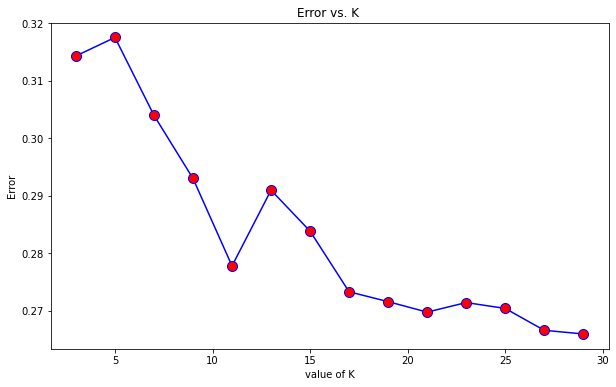

Minimum error 0.2659346545259775 at K =  13


In [261]:
scores_list = []

for i in range(3, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    scores_list.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(3, 30, 2), scores_list, color='blue', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error vs. K ')
plt.xlabel('value of K')
plt.ylabel('Error')
plt.show()
print(f'Minimum error {min(scores_list)} at K =  {scores_list.index(min(scores_list))}')

Determining K visually

In [279]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)


True Positive Rate: 0.85 
True Negative Rate: 0.58
Accuracy: 0.72
Mean Squared Error: 0.28
F1 Score: 0.66

10 Fold Validation accuracy: 0.70


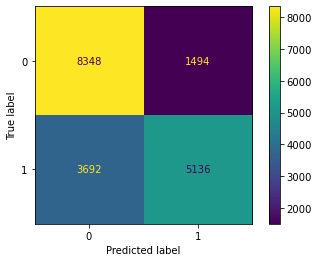

In [280]:
report(y_test, knn_pred)
validation(knn, X, Y, 10)

### 2) Naive Bayesian

In [268]:
gnb = GaussianNB().fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)


True Positive Rate: 0.22 
True Negative Rate: 1.00
Accuracy: 0.59
Mean Squared Error: 0.41
F1 Score: 0.70

10 Fold Validation accuracy: 0.59


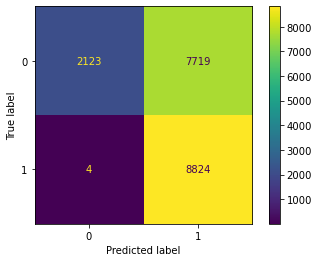

In [269]:
report(y_test, gnb_pred)
validation(gnb, X, Y, 10)

## 3) Decision Tree

In [270]:
dt = DecisionTreeClassifier().fit(x_train, y_train)
dt_pred = dt.predict(x_test)


True Positive Rate: 0.83 
True Negative Rate: 0.65
Accuracy: 0.74
Mean Squared Error: 0.26
F1 Score: 0.70

10 Fold Validation accuracy: 0.73


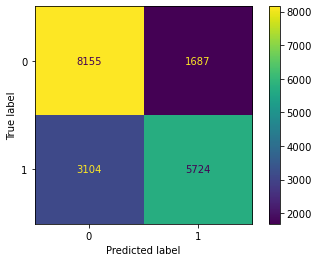

In [271]:
report(y_test, dt_pred)
validation(dt, X, Y, 10)

### 4) Logistic Regression

In [272]:
lr = LogisticRegression().fit(x_train, y_train)
lr_pred = lr.predict(x_test)


True Positive Rate: 0.39 
True Negative Rate: 0.85
Accuracy: 0.61
Mean Squared Error: 0.39
F1 Score: 0.67

10 Fold Validation accuracy: 0.61


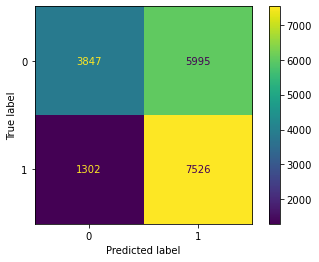

In [273]:
report(y_test, lr_pred)
validation(lr, X, Y, 10)

### 5) Neural Net

In [ ]:
model = Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[1],)))
model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='softmax'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
plot_learning_curve(history)